# Example2: Localization for single events

In this notebook I will show how to localize a GW event with seal.

In [1]:
import bilby
import numpy as np 
import time
import sys
import matplotlib.pyplot as plt
from multiprocessing import Pool
import multiprocessing
from functools import partial
from matplotlib.pyplot import MultipleLocator
from bilby.gw import conversion
from scipy.optimize import leastsq
import json
from pycbc.filter import matched_filter,matched_filter_core
from pycbc.types.timeseries import TimeSeries
from pycbc.types.frequencyseries import FrequencySeries
from lal import LIGOTimeGPS

import sealgw
from sealgw import seal
import sealgw.calculation as sealcal
import sealgw.simulation as sealsim

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Case I: Localizing SPIIR trigger events

Seal is going to be implemented in SPIIR, here I show how to process .xml file from SPIIR and localize it.

### Extract information and do it manually

You can extract event information from xml file and provide it to Seal manually. Same function can be used for your own GW events.


In [2]:
# Initialize Seal

seal_O4 = seal.Seal('example_outputs/config_multiple_saving_example.json', source_type='BNS') # use the config we fit in example1
xml_filepath = 'example_inputs/H1L1V1_1000605649_59_626.xml'

# extract_info_from_xml returns a lot of useful data that seal needs
# return_names==True: return det names
# return_names==False: return det codes
#  Note here snr_arrays, time_arrays are 1-D arrays, SNR series and timestamps from different detectors are connected to 1-D. 
#  ntimes_array stores the length of each detector, i.e., 
#  the first ntimes_array[0] elements in snr_arrays, is the snr series of 1st detector. Same for timestamps.
#  from ntimes_array[0]+1 to ntimes_array[0]+ntimes_array[1] are elements for 2nd detector.
#  Seal.localize take 1-D array, here is auto-converted when reading xml file. But if you are using your own SNR, remember to convert.
#  See simulation examples below.
trigger_time, ndet, ntimes_array, det_names, max_snr_array, sigma_array, time_arrays, snr_arrays =\
        sealcal.localization.extract_info_from_xml(xml_filepath, return_names=True)

#can be converted with:
#det_codes_array = sealcal.localization.get_det_code_array(det_names)

In [3]:
time_prior_width = 0.02  # Earth radius / light speed
start_time = trigger_time - time_prior_width 
end_time = trigger_time + time_prior_width 


In [4]:
# localize with seal. If you set timecost=False, it doesn't return timecost.

nthread =4  # number of threads you want to use
max_snr = sum(snr**2 for snr in max_snr_array)
max_snr = max_snr**0.5
logprob_skymap, timecost = seal_O4.localize( det_names, time_arrays, snr_arrays, max_snr, sigma_array, ntimes_array, start_time, end_time,
         nthread, interp_factor=8, timecost=True)

print("Timecost (s): ", timecost)

Timecost (s):  0.9870920181274414


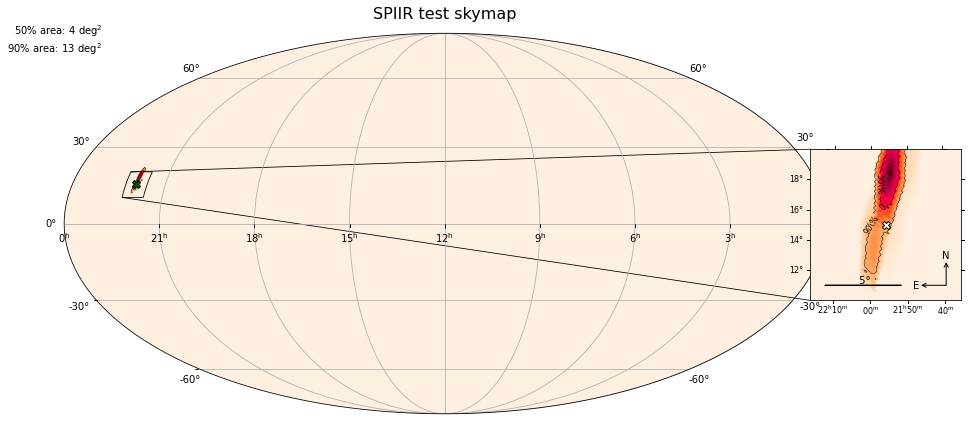

In [5]:
# plot it.
save_filename = 'example_outputs/skymap_SPIIR_trigger.pdf'
true_ra = 5.7416306
true_dec = 0.26279837

zoomin_truth = True
zoomin_maxprob = False
title = "SPIIR test skymap"
figsize = (14, 7)
    
fig = sealcal.localization.plot_skymap(logprob_skymap, save_filename=save_filename, true_ra = true_ra, true_dec = true_dec,
                                      zoomin_truth=zoomin_truth, zoomin_maxprob=zoomin_maxprob, title=title,figsize=figsize)

To save the prob density skymap as .fits file, we can simply use ligo.skymap:

In [6]:
import ligo.skymap.io.fits
from datetime import datetime
fits_file_name = 'example_outputs/skymap_SPIIR_trigger.fits'
now = datetime.now()
dt_string = now.strftime("%Y-%m-%dT%H:%M:%S")
fits_createtime = dt_string

prob_skymap = sealcal.localization.normalize_log_probabilities(logprob_skymap)
# To do: check if vcs_version, vcs_revision, build_date are what needed.
# https://lscsoft.docs.ligo.org/ligo.skymap/_modules/ligo/skymap/io/fits.html#read_sky_map
ligo.skymap.io.fits.write_sky_map(fits_file_name, prob_skymap, nest=True,
                vcs_version='SealGW 0.01', vcs_revision='bar',
                build_date=dt_string)

and read from .fits:

In [7]:
prob_skymap_from_fits = ligo.skymap.io.fits.read_sky_map(fits_file_name,  nest=True)
prob_skymap_from_fits

(array([1.96140796e-55, 1.96140796e-55, 1.96140796e-55, ...,
        1.32518022e-22, 1.32518022e-22, 1.32518022e-22]),
 OrderedDict([('nest', True),
              ('vcs_version', 'SealGW 0.01'),
              ('vcs_revision', 'bar'),
              ('build_date', '2023-03-20T20:37:40')]))

In [8]:
# check if they are the same array
(prob_skymap_from_fits[0] == prob_skymap).all()

True

### Let seal do it automatically

The above process can be done by seal. It's convenient to let seal do this inside, but you cannot see what info is stored in xml.

...waiting to fix trigger time and sigma issue in xml...

## Case II: Localizing your simulation events

Seal provides snr_generator to help you generate SNR timeseries (in the format of pycbc timeseries) and sigmas. 

You just need to provide detector, waveform generator, injection parameter (in bilby style), call the snr_generator, and pass the variables. You may need to reshape some variables before passing.

## BNS

In [9]:
injection_parameters = dict(mass_1 = 1.4, mass_2 = 1.4, chi_1=0.02, chi_2=0.01, lambda_1=425, lambda_2=425,
                            luminosity_distance=100., theta_jn=0.4, psi=2.6, phase=1.3, geocent_time=1126259642.4, ra=2.1, dec=1.2)

duration = 320. # 16
sampling_frequency = 4096


waveform_arguments = dict(waveform_approximant='TaylorF2', minimum_frequency=20.)


waveform_generator = bilby.gw.WaveformGenerator(
    duration=duration, sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_binary_neutron_star,
    waveform_arguments=waveform_arguments)

det_names = ['H1', 'L1', 'V1']

ifos = bilby.gw.detector.InterferometerList(det_names)

psd_files = ['example_inputs/H1_psd.txt','example_inputs/L1_psd.txt', 'example_inputs/V1_psd.txt']
# if your want to use your own PSD
for i in range(len(ifos)):
    det = ifos[i]
    psd_file = psd_files[i]
    psd = bilby.gw.detector.PowerSpectralDensity(psd_file=psd_file)
    det.power_spectral_density = psd 

ifos.set_strain_data_from_power_spectral_densities(
    sampling_frequency=sampling_frequency, duration=duration,
    start_time=injection_parameters['geocent_time'] - duration + 1)

ifos.inject_signal(waveform_generator=waveform_generator,
                parameters=injection_parameters)



20:37 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_neutron_star
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
20:37 bilby INFO    : Injected signal in H1:
20:37 bilby INFO    :   optimal SNR = 7.22
20:37 bilby INFO    :   matched filter SNR = 5.98-0.28j
20:37 bilby INFO    :   mass_1 = 1.4
20:37 bilby INFO    :   mass_2 = 1.4
20:37 bilby INFO    :   chi_1 = 0.02
20:37 bilby INFO    :   chi_2 = 0.01
20:37 bilby INFO    :   lambda_1 = 425
20:37 bilby INFO    :   lambda_2 = 425
20:37 bilby INFO    :   luminosity_distance = 100.0
20:37 bilby INFO    :   theta_jn = 0.4
20:37 bilby INFO    :   psi = 2.6
20:37 bilby INFO    :   phase = 1.3
20:37 bilby INFO    :   geocent_time = 1126259642.4
20:37 bilby INFO    :   ra = 2.1
20:37 bilby INFO    :   dec = 1.2
20:37 bilby INFO    : Injected signal in L1:
20:37 bilby INFO    :   optimal SNR = 9.38
20:37 bilby 

[{'plus': array([ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j, ...,
         -4.10580446e-27-1.16500555e-25j, -4.09971980e-27-1.16500562e-25j,
         -4.09363520e-27-1.16500568e-25j]),
  'cross': array([ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j, ...,
         -1.16107796e-25+4.09196253e-27j, -1.16107803e-25+4.08589838e-27j,
         -1.16107809e-25+4.07983430e-27j])},
 {'plus': array([ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j, ...,
         -4.10580446e-27-1.16500555e-25j, -4.09971980e-27-1.16500562e-25j,
         -4.09363520e-27-1.16500568e-25j]),
  'cross': array([ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j, ...,
         -1.16107796e-25+4.09196253e-27j, -1.16107803e-25+4.08589838e-27j,
         -1.16107809e-25+4.07983430e-27j])},


In [10]:
# Generate SNR and sigma
snr_list, sigma_list = sealsim.generating_data.snr_generator(ifos, waveform_generator, injection_parameters)

injection tc:  1126259642.4
Max snr time: 1126259642.3865724, SNR = 6.00614918411463


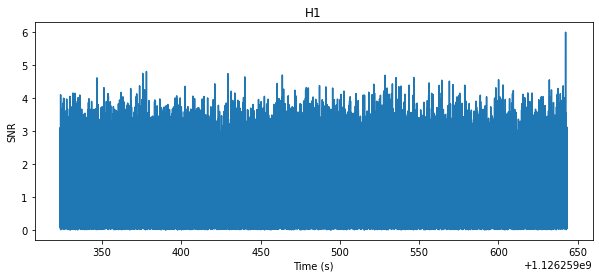

Max snr time: 1126259642.387793, SNR = 10.355539543082857


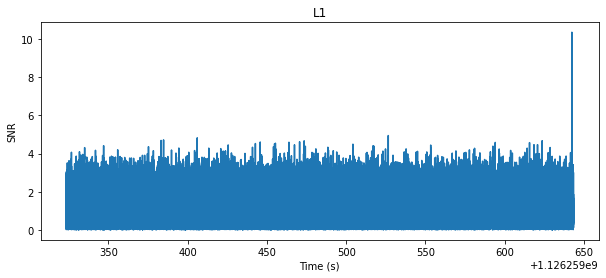

Max snr time: 1126259403.0096192, SNR = 5.617601220018413


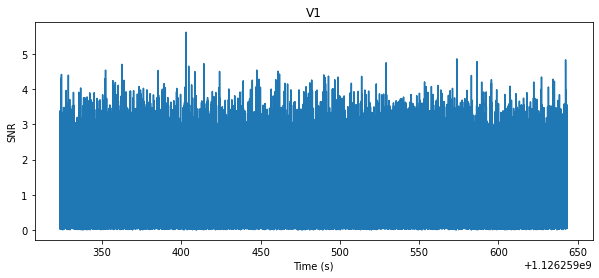

Max network SNR:  13.223784281261771


In [11]:
# Take a look at SNR we have
print('injection tc: ', injection_parameters['geocent_time'])
max_snr_sq = 0

det_id = 0
for snr in snr_list:
    peak = abs(snr).numpy().argmax()
    snrp = snr[peak]
    max_snr_sq += abs(snrp)**2
    time = snr.sample_times[peak]
    print('Max snr time: {}, SNR = {}'.format( time , abs(snrp)) )
    
    plt.figure(figsize=[10, 4])
    plt.plot(snr.sample_times, abs(snr))
    plt.ylabel('SNR')
    plt.xlabel('Time (s)')
    plt.title(det_names[det_id])
    plt.show()
    
    det_id +=1

print('Max network SNR: ', max_snr_sq**0.5)

In [12]:

nthread = 4

det_names = ['H1', 'L1', 'V1']

# Rearrange some variables: snr_arrays, time_arrays are 1-D array
time_arrays = np.array([])
snr_arrays = np.array([])
ntimes_array = np.array([])
for snr in snr_list:
    snr_arrays = np.append(snr_arrays, snr.data)
    time_arrays = np.append(time_arrays, snr.sample_times.data)
    ntimes_array = np.append(ntimes_array, len(snr.sample_times.data))

max_snr = max_snr_sq**0.5
sigma_array = np.array(sigma_list)

start_time = injection_parameters['geocent_time'] - 0.01
end_time = injection_parameters['geocent_time'] + 0.01

seal_sim = seal.Seal('example_outputs/sealconfig_bilby_lhv_BNS.txt')
logprob_skymap, timecost = seal_sim.localize( det_names, time_arrays, snr_arrays, max_snr, sigma_array, ntimes_array, start_time, end_time,
         nthread,  timecost=True, interp_factor=10)

print("Timecost (s): ", timecost)

Timecost (s):  1.2300329208374023


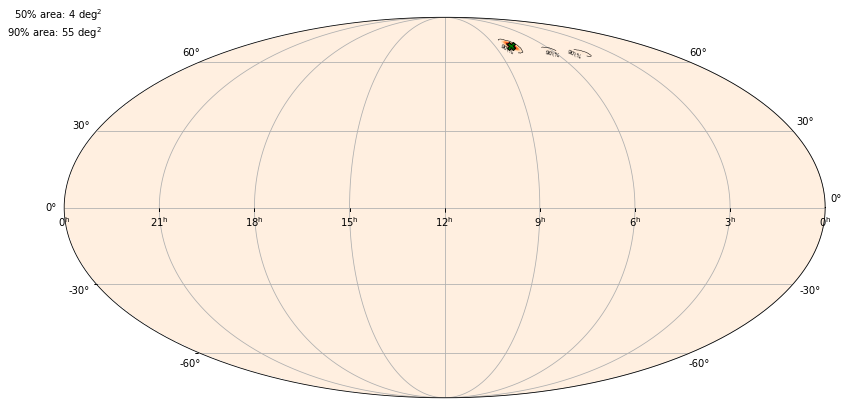

In [13]:
true_ra = injection_parameters['ra']
true_dec = injection_parameters['dec']

# We don't save skymap this time, just plot
fig = sealcal.localization.plot_skymap(logprob_skymap, true_ra = true_ra, true_dec = true_dec)

In [14]:
# Confidence area
sealcal.localization.confidence_area(logprob_skymap, [50, 90])

array([ 4.27515201, 54.79013828])

In [15]:
# Search area
sealcal.localization.search_area(logprob_skymap, true_ra, true_dec)

0.15736755847709377

## BBH



In [16]:
injection_parameters = dict(mass_1 = 16, mass_2 = 14,a_1=0, a_2=0, tilt_1=0,tilt_2=0, phi_12=0, phi_jl=0,
                            luminosity_distance=900., theta_jn=0.4, psi=2.6, phase=1.3, geocent_time=1126259642.4, ra=2.1, dec=1.2)

duration = 16. # 16
sampling_frequency = 4096


waveform_arguments = dict(waveform_approximant='IMRPhenomPv2', minimum_frequency=20.)


waveform_generator = bilby.gw.WaveformGenerator(
    duration=duration, sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    waveform_arguments=waveform_arguments)

det_names = ['H1', 'L1', 'V1']

ifos = bilby.gw.detector.InterferometerList(det_names)

'''
psd_files = ['example_inputs/H1_psd.txt','example_inputs/L1_psd.txt', 'example_inputs/V1_psd.txt']
# if your want to use your own PSD
for i in range(len(ifos)):
    det = ifos[i]
    psd_file = psd_files[i]
    psd = bilby.gw.detector.PowerSpectralDensity(psd_file=psd_file)
    det.power_spectral_density = psd 
'''
ifos.set_strain_data_from_power_spectral_densities(
    sampling_frequency=sampling_frequency, duration=duration,
    start_time=injection_parameters['geocent_time'] - duration + 1)

ifos.inject_signal(waveform_generator=waveform_generator,
                parameters=injection_parameters)



20:37 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
20:37 bilby INFO    : Injected signal in H1:
20:37 bilby INFO    :   optimal SNR = 14.55
20:37 bilby INFO    :   matched filter SNR = 15.79-0.57j
20:37 bilby INFO    :   mass_1 = 16
20:37 bilby INFO    :   mass_2 = 14
20:37 bilby INFO    :   a_1 = 0
20:37 bilby INFO    :   a_2 = 0
20:37 bilby INFO    :   tilt_1 = 0
20:37 bilby INFO    :   tilt_2 = 0
20:37 bilby INFO    :   phi_12 = 0
20:37 bilby INFO    :   phi_jl = 0
20:37 bilby INFO    :   luminosity_distance = 900.0
20:37 bilby INFO    :   theta_jn = 0.4
20:37 bilby INFO    :   psi = 2.6
20:37 bilby INFO    :   phase = 1.3
20:37 bilby INFO    :   geocent_time = 1126259642.4
20:37 bilby INFO    :   ra = 2.1
20:37 bilby INFO    :   dec = 1.2
20:37 bilby INFO    : Injected signal in L1:
20:37

[{'plus': array([0.-0.j, 0.-0.j, 0.-0.j, ..., 0.-0.j, 0.-0.j, 0.-0.j]),
  'cross': array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j])},
 {'plus': array([0.-0.j, 0.-0.j, 0.-0.j, ..., 0.-0.j, 0.-0.j, 0.-0.j]),
  'cross': array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j])},
 {'plus': array([0.-0.j, 0.-0.j, 0.-0.j, ..., 0.-0.j, 0.-0.j, 0.-0.j]),
  'cross': array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j])}]

In [17]:
# Generate SNR and sigma
snr_list, sigma_list = sealsim.generating_data.snr_generator(ifos, waveform_generator, injection_parameters)

injection tc:  1126259642.4
Max snr time: 1126259642.3863282, SNR = 15.909545377077993


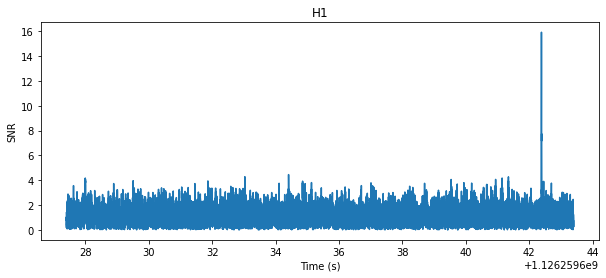

Max snr time: 1126259642.387793, SNR = 13.020944085916856


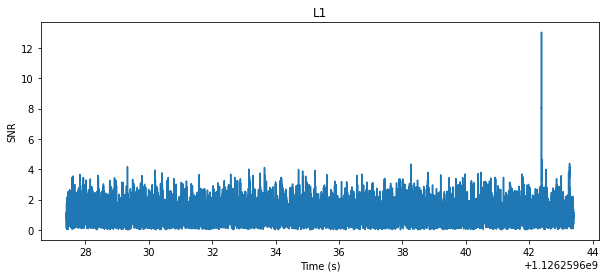

Max snr time: 1126259642.3814454, SNR = 13.81324582301054


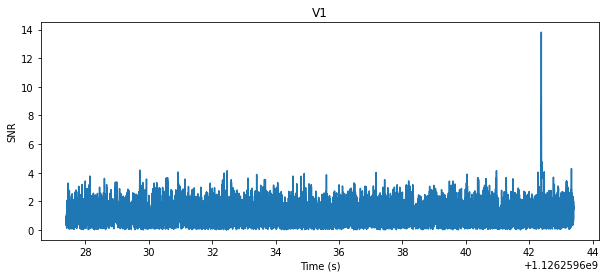

Max network SNR:  24.76821307968734


In [18]:
# Take a look at SNR we have
print('injection tc: ', injection_parameters['geocent_time'])
max_snr_sq = 0

det_id = 0
for snr in snr_list:
    peak = abs(snr).numpy().argmax()
    snrp = snr[peak]
    max_snr_sq += abs(snrp)**2
    time = snr.sample_times[peak]
    print('Max snr time: {}, SNR = {}'.format( time , abs(snrp)) )
    
    plt.figure(figsize=[10, 4])
    plt.plot(snr.sample_times, abs(snr))
    plt.ylabel('SNR')
    plt.xlabel('Time (s)')
    plt.title(det_names[det_id])
    plt.show()
    
    det_id +=1

print('Max network SNR: ', max_snr_sq**0.5)

In [19]:

nthread = 4

det_names = ['H1', 'L1', 'V1']

# Rearrange some variables: snr_arrays, time_arrays are 1-D array
time_arrays = np.array([])
snr_arrays = np.array([])
ntimes_array = np.array([])
for snr in snr_list:
    snr_arrays = np.append(snr_arrays, snr.data)
    time_arrays = np.append(time_arrays, snr.sample_times.data)
    ntimes_array = np.append(ntimes_array, len(snr.sample_times.data))

max_snr = max_snr_sq**0.5
sigma_array = np.array(sigma_list)

start_time = injection_parameters['geocent_time'] - 0.01
end_time = injection_parameters['geocent_time'] + 0.01

seal_sim = seal.Seal('example_outputs/sealconfig_bilby_lhv_BBH.txt')
logprob_skymap, timecost = seal_sim.localize( det_names, time_arrays, snr_arrays, max_snr, sigma_array, ntimes_array, start_time, end_time,
         nthread,  timecost=True, interp_factor=8)

print("Timecost (s): ", timecost)

Timecost (s):  0.9293231964111328


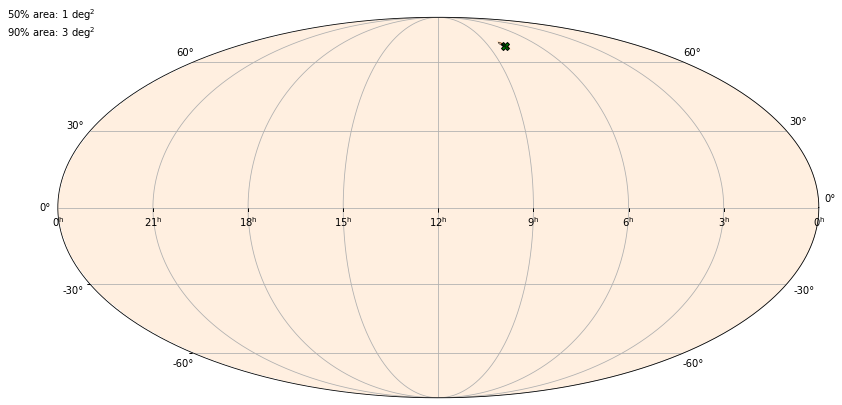

In [20]:
true_ra = injection_parameters['ra']
true_dec = injection_parameters['dec']

# We don't save skymap this time, just plot
fig = sealcal.localization.plot_skymap(logprob_skymap, true_ra = true_ra, true_dec = true_dec)

In [21]:
# Confidence area
sealcal.localization.confidence_area(logprob_skymap, [50, 90])

array([0.73438194, 3.0293255 ])

In [22]:
# Search area
sealcal.localization.search_area(logprob_skymap, true_ra, true_dec)

0.36719096977988547

## NSBH



In [23]:
injection_parameters = dict(mass_1 = 20, mass_2 = 1.4,a_1=0, a_2=0, tilt_1=0,tilt_2=0, phi_12=0, phi_jl=0,lambda_1=0,lambda_2=425,
                            luminosity_distance=500., theta_jn=0.4, psi=2.6, phase=1.3, geocent_time=1126259642.4, ra=2.1, dec=1.2)

duration = 32. # 16
sampling_frequency = 4096


waveform_arguments = dict(waveform_approximant='IMRPhenomNSBH', minimum_frequency=20.)


waveform_generator = bilby.gw.WaveformGenerator(
    duration=duration, sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_binary_neutron_star,
    waveform_arguments=waveform_arguments)

det_names = ['H1', 'L1', 'V1']

ifos = bilby.gw.detector.InterferometerList(det_names)

'''
psd_files = ['example_inputs/H1_psd.txt','example_inputs/L1_psd.txt', 'example_inputs/V1_psd.txt']
# if your want to use your own PSD
for i in range(len(ifos)):
    det = ifos[i]
    psd_file = psd_files[i]
    psd = bilby.gw.detector.PowerSpectralDensity(psd_file=psd_file)
    det.power_spectral_density = psd 
'''
ifos.set_strain_data_from_power_spectral_densities(
    sampling_frequency=sampling_frequency, duration=duration,
    start_time=injection_parameters['geocent_time'] - duration + 1)

ifos.inject_signal(waveform_generator=waveform_generator,
                parameters=injection_parameters)



20:37 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_neutron_star
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
20:37 bilby INFO    : Injected signal in H1:
20:37 bilby INFO    :   optimal SNR = 9.36
20:37 bilby INFO    :   matched filter SNR = 9.68-0.05j
20:37 bilby INFO    :   mass_1 = 20
20:37 bilby INFO    :   mass_2 = 1.4
20:37 bilby INFO    :   a_1 = 0
20:37 bilby INFO    :   a_2 = 0
20:37 bilby INFO    :   tilt_1 = 0
20:37 bilby INFO    :   tilt_2 = 0
20:37 bilby INFO    :   phi_12 = 0
20:37 bilby INFO    :   phi_jl = 0
20:37 bilby INFO    :   lambda_1 = 0
20:37 bilby INFO    :   lambda_2 = 425
20:37 bilby INFO    :   luminosity_distance = 500.0
20:37 bilby INFO    :   theta_jn = 0.4
20:37 bilby INFO    :   psi = 2.6
20:37 bilby INFO    :   phase = 1.3
20:37 bilby INFO    :   geocent_time = 1126259642.4
20:37 bilby INFO    :   ra = 2.1
20:37 b

[{'plus': array([0.00000000e+00+0.00000000e+00j, 0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j, ...,
         5.27915121e-29+7.49131557e-29j, 5.27908092e-29+7.49068118e-29j,
         0.00000000e+00+0.00000000e+00j]),
  'cross': array([0.00000000e+00+0.00000000e+00j, 0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j, ...,
         7.46606004e-29-5.26135357e-29j, 7.46542779e-29-5.26128351e-29j,
         0.00000000e+00+0.00000000e+00j])},
 {'plus': array([0.00000000e+00+0.00000000e+00j, 0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j, ...,
         5.27915121e-29+7.49131557e-29j, 5.27908092e-29+7.49068118e-29j,
         0.00000000e+00+0.00000000e+00j]),
  'cross': array([0.00000000e+00+0.00000000e+00j, 0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j, ...,
         7.46606004e-29-5.26135357e-29j, 7.46542779e-29-5.26128351e-29j,
         0.00000000e+00+0.00000000e+00j])},
 {'plus': array([0.00000

In [24]:
# Generate SNR and sigma
snr_list, sigma_list = sealsim.generating_data.snr_generator(ifos, waveform_generator, injection_parameters)

injection tc:  1126259642.4
Max snr time: 1126259642.3865724, SNR = 9.691235058497574


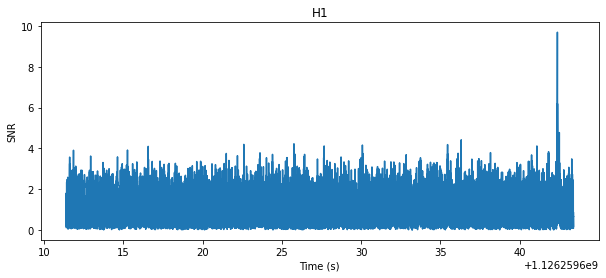

Max snr time: 1126259642.387549, SNR = 6.594080847124197


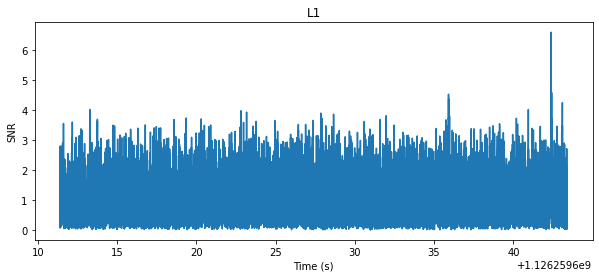

Max snr time: 1126259642.3816895, SNR = 8.664557192337885


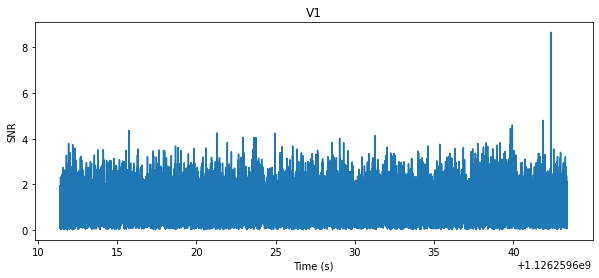

Max network SNR:  14.57657334618657


In [25]:
# Take a look at SNR we have
print('injection tc: ', injection_parameters['geocent_time'])
max_snr_sq = 0

det_id = 0
for snr in snr_list:
    peak = abs(snr).numpy().argmax()
    snrp = snr[peak]
    max_snr_sq += abs(snrp)**2
    time = snr.sample_times[peak]
    print('Max snr time: {}, SNR = {}'.format( time , abs(snrp)) )
    
    plt.figure(figsize=[10, 4])
    plt.plot(snr.sample_times, abs(snr))
    plt.ylabel('SNR')
    plt.xlabel('Time (s)')
    plt.title(det_names[det_id])
    plt.show()
    
    det_id +=1

print('Max network SNR: ', max_snr_sq**0.5)

In [26]:

nthread = 4

det_names = ['H1', 'L1', 'V1']

# Rearrange some variables: snr_arrays, time_arrays are 1-D array
time_arrays = np.array([])
snr_arrays = np.array([])
ntimes_array = np.array([])
for snr in snr_list:
    snr_arrays = np.append(snr_arrays, snr.data)
    time_arrays = np.append(time_arrays, snr.sample_times.data)
    ntimes_array = np.append(ntimes_array, len(snr.sample_times.data))

max_snr = max_snr_sq**0.5
sigma_array = np.array(sigma_list)

start_time = injection_parameters['geocent_time'] - 0.01
end_time = injection_parameters['geocent_time'] + 0.01

seal_sim = seal.Seal('example_outputs/sealconfig_bilby_lhv_NSBH.txt')
logprob_skymap, timecost = seal_sim.localize( det_names, time_arrays, snr_arrays, max_snr, sigma_array, ntimes_array, start_time, end_time,
         nthread,  timecost=True, interp_factor=8)

print("Timecost (s): ", timecost)

Timecost (s):  0.9769489765167236


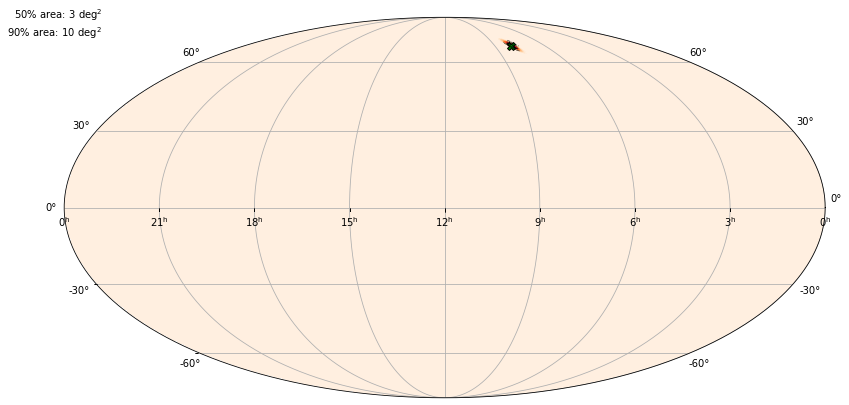

In [27]:
true_ra = injection_parameters['ra']
true_dec = injection_parameters['dec']

# We don't save skymap this time, just plot
fig = sealcal.localization.plot_skymap(logprob_skymap, true_ra = true_ra, true_dec = true_dec)

In [28]:
# Confidence area
sealcal.localization.confidence_area(logprob_skymap, [50, 90])

array([2.79327416, 9.61253503])

In [29]:
# Search area
sealcal.localization.search_area(logprob_skymap, true_ra, true_dec)

0.31473511695418754